## Problem 2.2 (Exploring fish sleep data)

In [1]:
import numpy as np
import pandas as pd
import itertools

import altair as alt
import altair_catplot as altcat

alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

Our goal for this problem is to come up with two metrics to parameterize sleep behavior using datasets that describe the movement of zebrafish larvae over time for wild type, heterozygous mutant, and homozygous mutant zebrafish.

### Tidying Data

The first step is to combine and tidy our genotype and behavioral datasets. Let's first read in the genotype dataset.

In [2]:
df_gt = pd.read_csv('../data/130315_1A_genotypes.txt',
                    delimiter='\t',
                    comment='#',
                    header=[0, 1])
# Take a look
df_gt.head()

,Genotype1,Genotype2,Genotype3
,WT 17,Het 34,Mut 22
0,2.0,1,4.0
1,14.0,3,11.0
2,18.0,5,12.0
3,24.0,6,13.0
4,28.0,8,20.0


Let's start to tidy up the data by first resetting and renaming the columns.

In [3]:
# Reset the columns to be the second level of indexing
df_gt.columns = df_gt.columns.get_level_values(1)

# Check out the new columns
df_gt.columns

Index(['WT 17', 'Het 34', 'Mut 22'], dtype='object')

In [4]:
# Rename the columns
df_gt.columns = ['wt', 'het', 'mut']

In [5]:
# Tidy the DataFrame
df_gt = pd.melt(df_gt, var_name='genotype', value_name='location')

# Take a look
df_gt.head()

,genotype,location
0,wt,2.0
1,wt,14.0
2,wt,18.0
3,wt,24.0
4,wt,28.0


We notice there are some rows with NaN values in them, so we will drop these rows.

In [6]:
# Drop all rows that have a NaN in them
df_gt = df_gt.dropna()

# Reset the index
df_gt = df_gt.reset_index(drop=True)

df_gt.head()

,genotype,location
0,wt,2.0
1,wt,14.0
2,wt,18.0
3,wt,24.0
4,wt,28.0


In [7]:
# Reset location values from floats to ints.
df_gt.loc[:,'location'] = df_gt.loc[:, 'location'].astype(int)

Now let's load in the behavioral data set to get the activity and temporal information for each location.

In [8]:
df = pd.read_csv('../data/130315_1A_aanat2.csv', comment='#')

# Take a look
df.head()

,location,activity,time,zeit,zeit_ind,day
0,1,0.6,2013-03-15 18:31:09,-14.480833,-869,4
1,2,1.4,2013-03-15 18:31:09,-14.480833,-869,4
2,3,0.0,2013-03-15 18:31:09,-14.480833,-869,4
3,4,0.0,2013-03-15 18:31:09,-14.480833,-869,4
4,5,0.0,2013-03-15 18:31:09,-14.480833,-869,4


Merge the two datasets to combine the behavioral data with the genotype data.

In [9]:
df = pd.merge(df, df_gt)

# Take a look
df.head()

,location,activity,time,zeit,zeit_ind,day,genotype
0,1,0.6,2013-03-15 18:31:09,-14.480833,-869,4,het
1,1,1.9,2013-03-15 18:32:09,-14.464167,-868,4,het
2,1,1.9,2013-03-15 18:33:09,-14.447500,-867,4,het
3,1,13.4,2013-03-15 18:34:09,-14.430833,-866,4,het
4,1,15.4,2013-03-15 18:35:09,-14.414167,-865,4,het


Now let's create a column called 'light' that will help us determine if the lights are on or off during the experiment. In this experiment, lights are turned on at 9AM and turned off at 11PM. We will set 'light' to True if the lights are on and False if the lights are off.

In [10]:
df['time'] = pd.to_datetime(df['time'])

In [11]:
df['light'] = (  (df['time'].dt.time >= pd.to_datetime('9:00:00').time())
               & (df['time'].dt.time < pd.to_datetime('23:00:00').time()))

# Take a look
df.head()

,location,activity,time,zeit,zeit_ind,day,genotype,light
0,1,0.6,2013-03-15 18:31:09,-14.480833,-869,4,het,True
1,1,1.9,2013-03-15 18:32:09,-14.464167,-868,4,het,True
2,1,1.9,2013-03-15 18:33:09,-14.447500,-867,4,het,True
3,1,13.4,2013-03-15 18:34:09,-14.430833,-866,4,het,True
4,1,15.4,2013-03-15 18:35:09,-14.414167,-865,4,het,True


### Determining sleep parameters

Now that we've cleaned up the data, let's first look at the overall activity for each genotype during the day and the night by plotting the ECDF.

In [12]:
# Make axes the same
axis_scale = alt.Scale(domain=[0, 55])

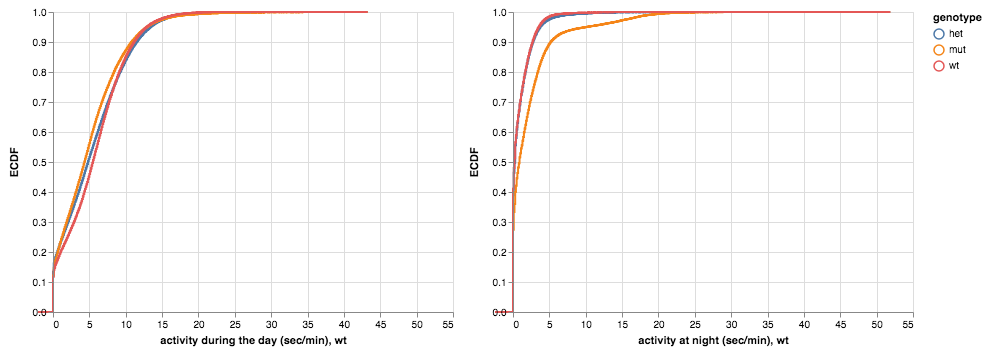

In [13]:
p1 = altcat.catplot(data=df.loc[df['light']==True, :],
                    mark='line',
                    encoding=dict(x=alt.X('activity:Q', scale=axis_scale, title='activity during the day (sec/min), wt'),
                                  color=alt.Color('genotype:N', sort=['wt', 'het', 'mut'])),
                    transform = 'ecdf')

p2 = altcat.catplot(data=df.loc[df['light']==False, :],
                    mark='line',
                    encoding=dict(x=alt.X('activity:Q', scale=axis_scale, title='activity at night (sec/min), wt'),
                                  color=alt.Color('genotype:N', sort=['wt', 'het', 'mut'])),
                    transform = 'ecdf')

p1 | p2

From these initial plots, we see that during the day, all three genotypes appear to have similar activity levels, but at night, the mutant zebrafish's activity is qualitatively different from the wild-type and heterozygous zebrafish.

We decided to look at the mean activity during the day and night on day 5 of a zebrafish's life, analyzing each fish separately. We chose the 5th day as the zebrafish's activity levels change each day as they develop, and the 5th day is the day used for analysis in Prober et. al. We are analyzing each fish's activity separately because when we plotted the activity traces for each individual fish, we saw that there appear to be two fish, in locations 21 and 67, that are up all night for some of the nights and were likely sick or died during the experiment.

First we need to group the data by location and light for day 5, taking out the sick fish. 

In [49]:
inds = ((df['day'] == 5)
       & (df['location'] != 21)
       & (df['location'] != 67))

grouped = df.loc[inds, :].groupby(['location', 'light', 'genotype'])

Now we can take the mean activity during the day and night for each fish on day 5. 

In [50]:
# Take the mean of the activity during day and night
df_mean = grouped['activity'].mean()

# Take a look
df_mean.head()

location  light  genotype
1         False  het         1.209667
          True   het         4.075866
2         False  wt          0.542500
          True   wt          6.136918
3         False  het         0.517500
Name: activity, dtype: float64

In [51]:
# Reset index 
df_mean = df_mean.reset_index()

In [52]:
# Rename the activity column to mean_activity.
df_mean = df_mean.rename(columns={'activity' : 'mean_activity'})

# Take a look
df_mean.head()

,location,light,genotype,mean_activity
0,1,False,het,1.209667
1,1,True,het,4.075866
2,2,False,wt,0.542500
3,2,True,wt,6.136918
4,3,False,het,0.517500


To be able to compare the activity between fish, we normalized the mean activity for each fish by dividing their mean activity during the day by their mean activity at night. 

\begin{align}
\mathrm{normalized \ mean \ activity_{day}} = &\frac{\mathrm{mean \ activity_{day}}}{\mathrm{mean \ activity_{night}}} \\[1em]
\mathrm{normalized \ mean \ activity_{night}} = &\frac{\mathrm{mean \ activity_{night}}}{\mathrm{mean \ activity_{night}}}
\end{align}

Using this normalization, a small mean activity would indicate that the fish is not sleeping well. Since we saw that the activity during the day for all genotypes is similar, a small mean activity means that the fish is more active at night and not asleep.

In [53]:
# Slice out mean activity during the day and night
day_activity = df_mean.loc[df_mean['light']==True, 'mean_activity']
night_activity = df_mean.loc[df_mean['light']==False, 'mean_activity']

# Normalize day and night activity
norm_day_activity = np.divide(day_activity, night_activity)
norm_night_activity = np.divide(night_activity, night_activity)

In [54]:
# Add normalized mean activity back into the dataframe
df_mean.loc[df_mean['light']==True, 'norm_mean_activity'] = norm_day_activity
df_mean.loc[df_mean['light']==False, 'norm_mean_activity'] = norm_night_activity

In [55]:
# Take a look
df_mean.head()

,location,light,genotype,mean_activity,norm_mean_activity
0,1,False,het,1.209667,1.000000
1,1,True,het,4.075866,3.369413
2,2,False,wt,0.542500,1.000000
3,2,True,wt,6.136918,11.312290
4,3,False,het,0.517500,1.000000


Now we can compare the median activity from day to night for each fish for each genotype. In this plot, the normalized mean activity at night is always 1. 

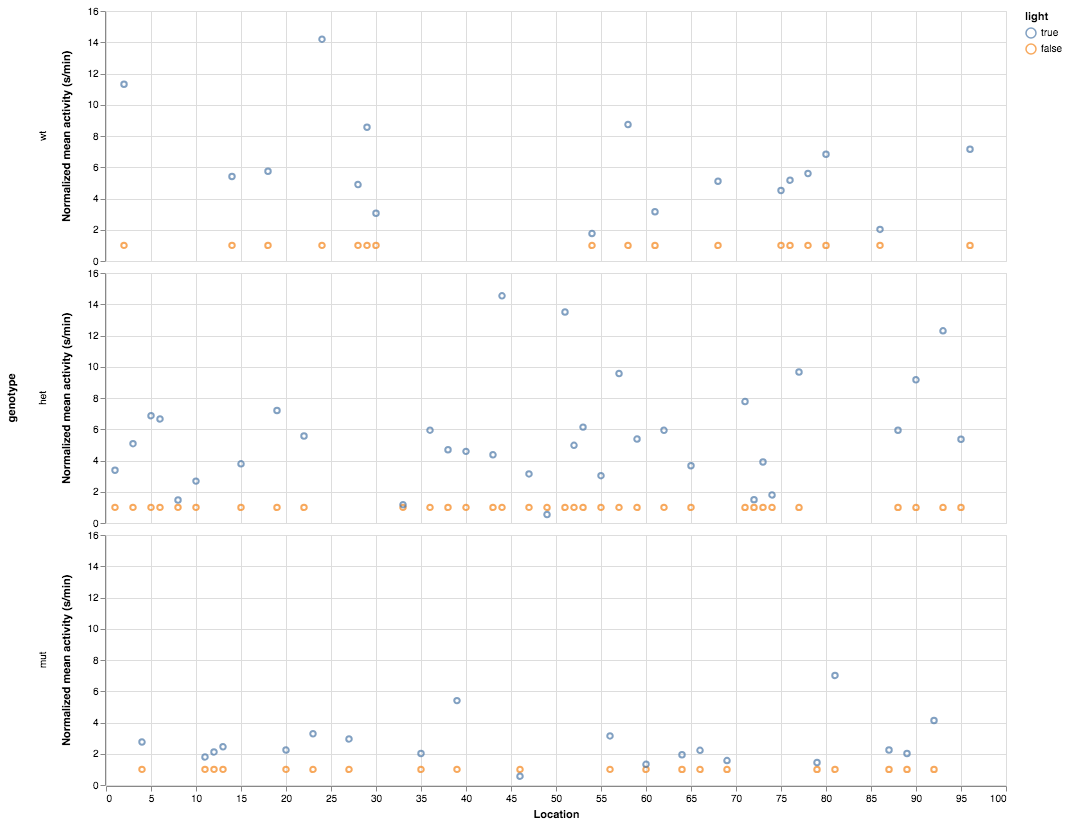

In [56]:
# Plot the normalized mean activity for each location through light/dark cycle
alt.Chart(df_mean, height=250, width=900
         ).mark_point(
         ).encode(
             x=alt.X('location:Q', title='Location'),
             y=alt.Y('norm_mean_activity:Q', title='Normalized mean activity (s/min)'),
             color=alt.Color('light:N', sort=[True, False]),
             row=alt.Row('genotype:N', sort=['wt', 'het', 'mut'])
         )

We can see that the mutant fishes have smaller normalized mean activities during the day, meaning that they are more active at night that the wild type or heterozygous zebrafish. 

Now let's plot the ECDF of the normalized mean activity.

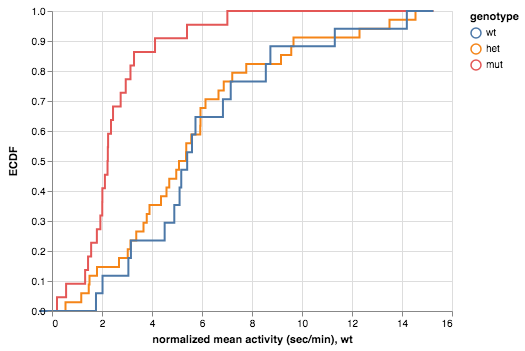

In [38]:
altcat.catplot(data=df_mean.loc[df_mean['light']==True, :],
               mark='line',
               encoding=dict(x=alt.X('norm_mean_activity:Q', 
                                     scale=alt.Scale(domain=[0,16]),
                                     title='normalized mean activity (sec/min), wt'),
                             color=alt.Color('genotype:N', sort=['wt', 'het', 'mut'])),
               transform = 'ecdf')

From the ECDF, we see that there is a greater percentage of mutant zebrafish with smaller normalized mean activity at all times compared to the wild-type and heterozygous fish. The ECDF indicates that the mutant fish are more active at night compared to the wild-type and heterzygotes, suggesting that they are not sleeping as well.

It may be more intuitive to be normalizing the activity at night by the activity during the day. In this case, a greater normalized mean activity would indicate more activity at night. We can do a check to see if we normalized the data differently, by dividing each fish's activity at night by their activity during the day, how the ECDF would look.

In [26]:
# Normalize day and night activity
norm_day_activity = np.divide(day_activity, day_activity)
norm_night_activity = np.divide(night_activity, day_activity)

In [27]:
df_mean.loc[df_mean['light']==True, 'norm_mean_activity_by_day'] = norm_day_activity
df_mean.loc[df_mean['light']==False, 'norm_mean_activity_by_day'] = norm_night_activity

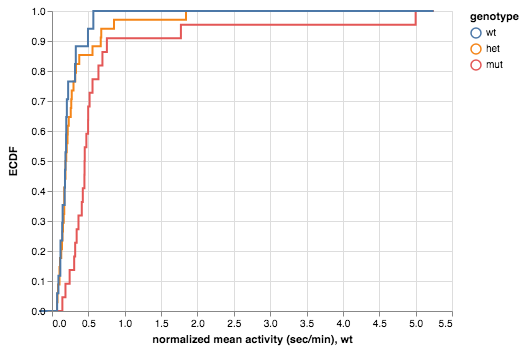

In [37]:
altcat.catplot(data=df_mean.loc[df_mean['light']==False, :],
               mark='line',
               encoding=dict(x=alt.X('norm_mean_activity_by_day:Q', 
                                     scale=alt.Scale(domain=[0,5.5]),
                                     title='normalized mean activity (sec/min), wt'),
                             color=alt.Color('genotype:N', sort=['wt', 'het', 'mut'])),
               transform = 'ecdf')

In this case, since a larger normalized mean activity means more activity at night, we see the same trend. The mutant fish are more active at night than the wild-type and heterogenous zebrafish.